# Steps

1. Calculate during how many cycles the equipment has failed
2. Categorize failed equipment by group
3. Categorize failed equipment by parameter (temperature, pressure and others)
4. Create a model using the technique you think is most appropriate and measure its performance
5. Analyze variable importance

In [1]:
#!pip install pandas-profiling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas_profiling as pp
import thiago
import sklearn.decomposition as skdc

pd.set_option('display.max_columns',None)


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
df=pd.read_excel('O&G Equipment Data.xlsx')

### 

In [4]:
df.describe()

Cycle    Preset_1    Preset_2  Temperature    Pressure  VibrationX  \
count  800.0000  800.000000  800.000000   800.000000  800.000000  800.000000   
mean   400.5000    1.988750    4.551250    69.263494   78.997945   73.860275   
std    231.0844    0.805875    2.293239    25.536252   32.501834   31.229631   
min      1.0000    1.000000    1.000000     2.089354    3.480279    3.846343   
25%    200.7500    1.000000    3.000000    51.040134   55.508564   50.752461   
50%    400.5000    2.000000    5.000000    65.906716   75.014848   69.394953   
75%    600.2500    3.000000    7.000000    80.527220   99.302530   90.195059   
max    800.0000    3.000000    8.000000   255.607829  189.995681  230.861142   

       VibrationY  VibrationZ   Frequency  
count  800.000000  800.000000  800.000000  
mean    72.786878   71.866211   68.223449  
std     32.739745   27.844616   29.138702  
min     10.057744   18.784169    4.380101  
25%     48.523982   50.787638   45.861762  
50%     65.504770   69.319237   65.664252  
75%     94.075572   88.891205   90.097457  
max    193.569947  230.951134  178.090303

In [5]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Missing data

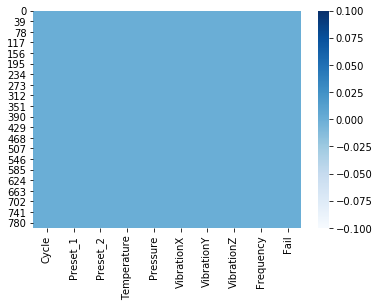

In [6]:
sb.heatmap(df.isna(),cmap='Blues')

There is no missing data, otherwise, there would be some white in the figure above.

# 1. Calculate during how many cycles the equipment has failed

In [7]:
df['end']=np.logical_and(df['Fail'],~df['Fail'].shift(-1).fillna(True))
df['start']=np.logical_and(df['Fail'],~df['Fail'].shift(1).fillna(True))
df['pre']=np.logical_and(~df['Fail'],df['Fail'].shift(-1).fillna(False))

In [8]:
fails=np.where(df.Fail)[0]

In [9]:
#Getting the intervals and points in which a failure happened
idx=np.zeros(len(fails))
for f in range(1,len(fails)):
    if fails[f-1]==fails[f]-1:
        idx[f]=1
ls=[]
for i in range(len(idx)-1):
    if idx[i]==0:
        if idx[i+1]==0:
            ls.append(idx[i])
        else:
            inf=i
            j=1
            while i+j<len(idx) and idx[i+j]==1:
                j+=1
            ls.append([i,i+j-1])

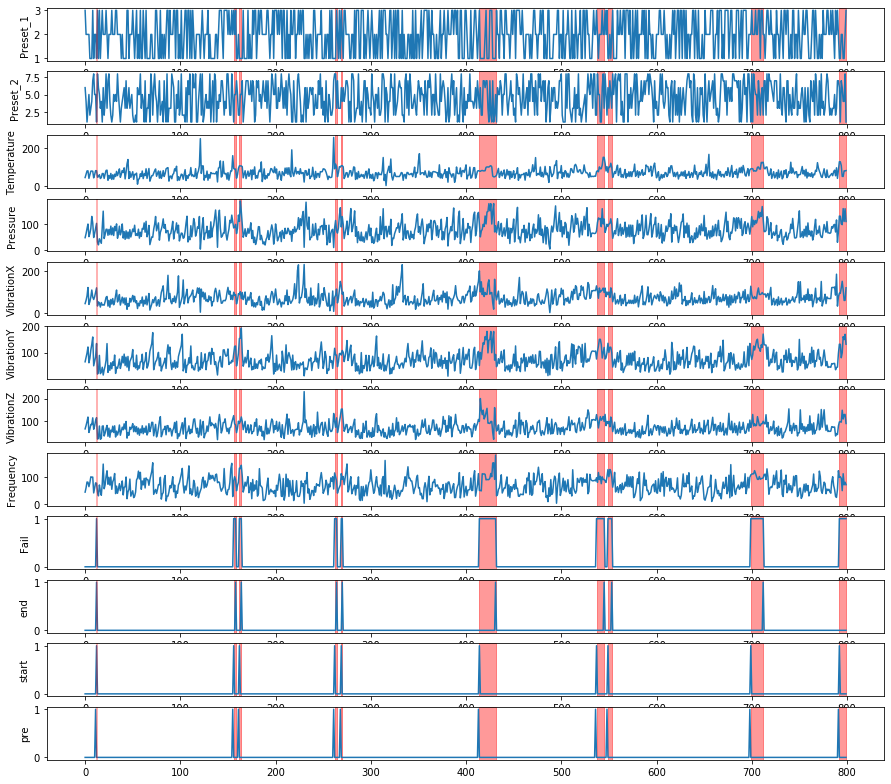

In [10]:
plt.figure(figsize=(15,15))
for i in range(1,13):
    plt.subplot(df.shape[1],1,i)
    plt.plot(df.iloc[:,i])
    plt.ylabel(df.columns[i])
    for f in ls:
        if hasattr(f,'__iter__'):
            plt.axvspan(fails[f[0]],fails[f[1]],color='r',alpha=0.4)
        else:
            plt.axvline(fails[int(f)],color='r',alpha=0.4)

When a failure happens, it's probable that there will be a failure also in the next cycle. In other words, we can see the number of failures as the full number of failed cycles or as the number of failures' start.<br>

In [11]:
print(f"Total number of failures: {df['Fail'].sum()}")
print(f"Total number of failure\'s starts: {df['start'].sum()}")

Total number of failures: 66
Total number of failure's starts: 10


From now on, we will approach this dataframe as it's a time series since the sequential failures suggests a time relation, even though we don't have timestamps. I'll split the data in 600th cycle. (important for the feature engineering)

# 2. Categorize failed equipment by group

First, I'll try to categorize the failures giving some reasons for the the failure sequence's start. Next, I'll split the failure sequence's start with an hierarquical clustering technique.

It seems that there are differents types of failures: overheating(e.g. around the 280th cycle) or vibration(e.g. around the 420th cycle) for example.

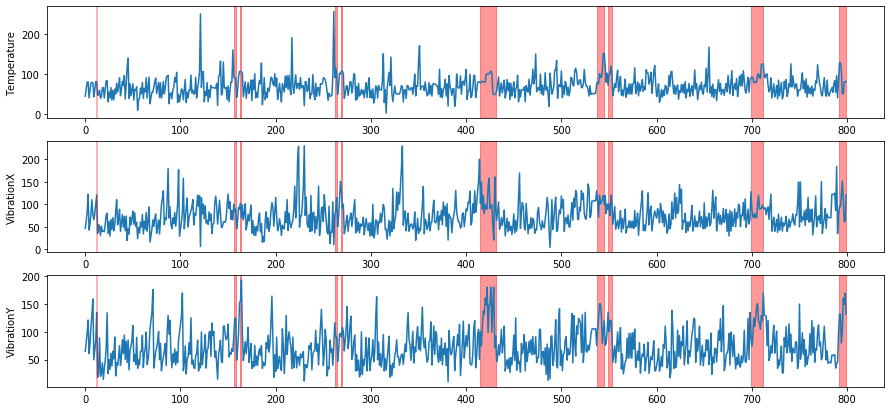

In [24]:
idx=[3,5,6]
plt.figure(figsize=(15,7))
for i in range(len(idx)):
    plt.subplot(len(idx),1,i+1)
    plt.plot(df.iloc[:,idx[i]])
    plt.ylabel(df.columns[idx[i]])
    for f in ls:
        if hasattr(f,'__iter__'):
            plt.axvspan(fails[f[0]],fails[f[1]],color='r',alpha=0.4)
        else:
            plt.axvline(fails[int(f)],color='r',alpha=0.4)

In [25]:
df['DeltaX']=(df['VibrationX']-df['VibrationX'].shift(1)).fillna(0)
df['DeltaY']=(df['VibrationY']-df['VibrationY'].shift(1)).fillna(0)
df['DeltaZ']=(df['VibrationZ']-df['VibrationZ'].shift(1)).fillna(0)
df['Previous_T']=df['Temperature'].shift(1).fillna(0)

In [26]:
df[['Previous_T','Temperature','start']].loc[260:]

Previous_T  Temperature  start
260   46.599957    93.552988  False
261   93.552988   255.607829  False
262  255.607829    90.295697   True
263   90.295697   115.278603  False
264  115.278603   100.986610  False
..          ...          ...    ...
795  107.452875    50.469522  False
796   50.469522    49.985270  False
797   49.985270    79.777294  False
798   79.777294    79.360314  False
799   79.360314    80.854011  False

[540 rows x 3 columns]

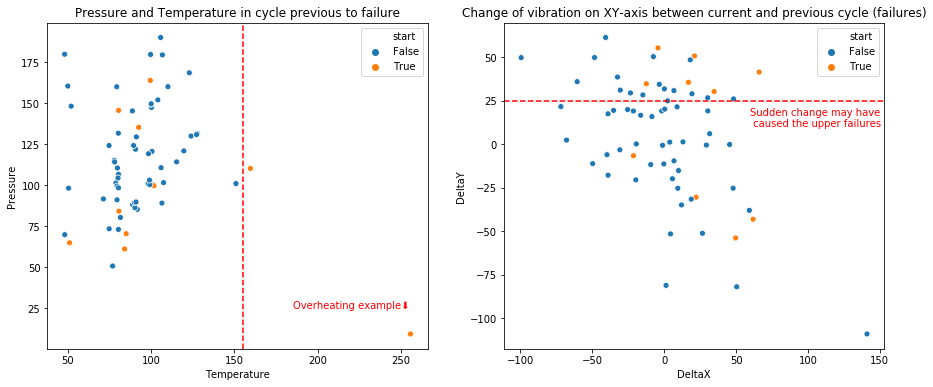

In [27]:
plt.figure(figsize=(15,6))
plt.subplot(121)
sb.scatterplot(df[df['Fail'].shift(-1)==True]['Temperature'],
               df[df['Fail'].shift(-1)==True]['Pressure'],hue=df['start'].shift(-1))
plt.title('Pressure and Temperature in cycle previous to failure')
plt.text(185,25,"Overheating example⬇",color='r')
plt.axvline(155,color='r',linestyle='--')
plt.subplot(122)
sb.scatterplot(df[df['Fail']]['DeltaX'],
               df[df['Fail']]['DeltaY'],hue=df['start'])
plt.title('Change of vibration on XY-axis between current and previous cycle (failures)')
plt.axhline(25,color='r',linestyle='--')
plt.text(60,10,"Sudden change may have\n caused the upper failures ",color='r');

#### Now, to hierarquical clustering

In [28]:
import scipy.cluster.hierarchy as hie
from sklearn.preprocessing import MinMaxScaler

In [29]:
df.columns

Index(['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail', 'end',
       'start', 'pre', 'DeltaX', 'DeltaY', 'DeltaZ', 'Previous_T'],
      dtype='object')

In [49]:
cols=['Temperature', 'Pressure','VibrationX', 'VibrationY', 'VibrationZ', 'Frequency','Previous_T']

In [50]:
df_X=df.loc[df['start'],cols]

In [51]:
sc=MinMaxScaler().fit(df_X[cols])

In [52]:
df_X=sc.transform(df_X)

In [53]:
link=hie.linkage(df_X)

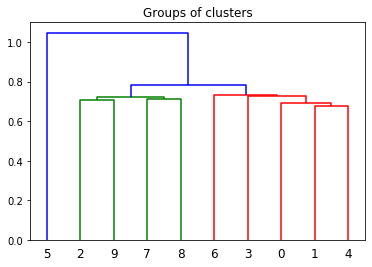

In [54]:
hie.dendrogram(link)
plt.title('Groups of clusters')
plt.show()

The dendogram shows the difference between the startpoints. The higher the split, bigger the difference between the cycles.<br>
The sixth cycle (5) is the overheating cycle, which is the only of its kind in this dataset.<br>
As for the green and red groups, their difference arise with a combination of the variables, e.g. the intensity of vibration on the Z-axis.

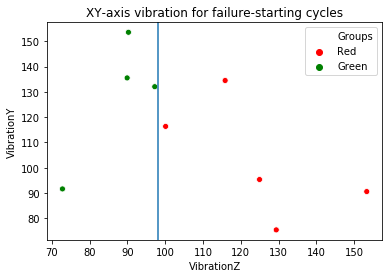

In [56]:
df_X=df.loc[df['start'],cols]
df_X['Groups']=[2,2,1,2,2,0,2,1,1,1]
df_X=df_X[df_X.Groups>0]
df_X.Groups=df_X.Groups.map({1:'Green',2:'Red'})

sb.scatterplot(df_X.VibrationZ,df_X.VibrationY,hue=df_X.Groups,palette=['r','g'])
plt.axvline(98)
plt.title('XY-axis vibration for failure-starting cycles');

# 3. Categorize failed equipment by parameter (temperature, pressure and others) 

In the previous section, we used the data to split the failure-starting cycles into groups. In this section, we'll try to split the failed cycles from the regular cycles.<br><br>

### Presets 1 & 2
We'll look to the presets now.<br>
In the first two following tables, we can see the proportion of failures by preset(1 & 2). We can see a slight increase in the failure proportion in <i>Preset_1</i> using the setup 1. Same goes for the setups 1 and 5 in <i>Preset_2</i>.

In [57]:
df_X=df.loc[:600]

In [58]:
df_X[['Preset_1','Fail']].groupby('Preset_1').mean().T

Preset_1         1        2         3
Fail      0.105263  0.05314  0.059459

In [59]:
df_X[['Preset_2','Fail']].groupby('Preset_2').mean().T

Preset_2         1         2         3         4    5         6         7  \
Fail      0.093333  0.085714  0.074074  0.013699  0.1  0.070423  0.093333   

Preset_2         8  
Fail      0.052632

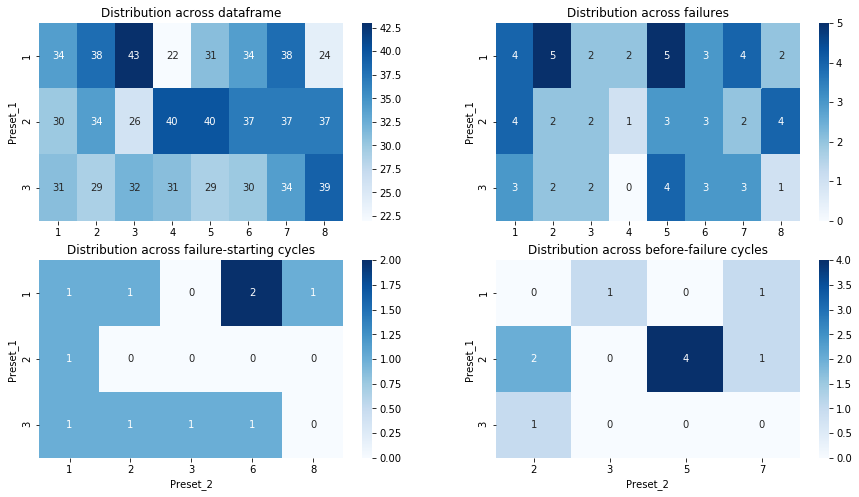

In [60]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.title('Distribution across dataframe')
sb.heatmap(thiago.table(df,'Preset_1','Preset_2'),annot=True,cmap='Blues');plt.xlabel('')
plt.subplot(222)
plt.title('Distribution across failures')
sb.heatmap(thiago.table(df[df.Fail],'Preset_1','Preset_2'),annot=True,cmap='Blues');plt.xlabel('')
plt.subplot(223)
plt.title('Distribution across failure-starting cycles')
sb.heatmap(thiago.table(df[df.start],'Preset_1','Preset_2'),annot=True,cmap='Blues')
plt.subplot(224)
plt.title('Distribution across before-failure cycles')
sb.heatmap(thiago.table(df[df.pre],'Preset_1','Preset_2'),annot=True,cmap='Blues')

What draws attention is:
- The increase of preset_1's setup 1 in the failures compared to the whole dataframe
- The predominance of setup 2 in preset_1's before-failure cycles 

Next, we'll get the information value of each of these states and check its relevance using a technique called "Weight of Evidence" (WOE). This technique states that if its information value(IV) is greater than 0.02 then this variable has some predictive power. The IV of a variable is the sum of the IV's of its labels. 

In [61]:
thiago.woe_iv(df_X,'Preset_1','Fail')

(3, 2)


[                 WOE        IV
 Preset_1_1 -0.398309  0.065431
 Preset_1_2  0.341844  0.034829
 Preset_1_3  0.222784  0.013899,
 0.11415925877572186]

In [62]:
thiago.woe_iv(df_X,'Preset_2','Fail')

(8, 2)


[                 WOE        IV
 Preset_2_1 -0.264778  0.009799
 Preset_2_2 -0.171252  0.003675
 Preset_2_3 -0.012647  0.000022
 Preset_2_4  1.738291  0.185192
 Preset_2_5 -0.341151  0.017929
 Preset_2_6  0.041841  0.000203
 Preset_2_7 -0.264778  0.009799
 Preset_2_8  0.351996  0.013501,
 0.24011961993587622]

Both variables have reasonable predictive power, therefore, we will resort to One-Hot Encoding.

In [63]:
for col in ['Preset_1','Preset_2']:
    df=pd.concat([df.drop(col,axis=1),pd.get_dummies(df[col],prefix=col,prefix_sep='@',drop_first=True)],axis=1)

In [64]:
for i in df.loc[:600].columns[df.loc[:600].columns.str.startswith('Preset_')]:
    print(f"IV of {i} variable: {thiago.woe_iv(df.loc[:600],i,'Fail')[1]}")

(2, 2)
IV of Preset_1@2 variable: 0.0497045424737093
(2, 2)
IV of Preset_1@3 variable: 0.019317294084190743
(2, 2)
IV of Preset_2@2 variable: 0.004202321058313428
(2, 2)
IV of Preset_2@3 variable: 2.507063084177671e-05
(2, 2)
IV of Preset_2@4 variable: 0.19748881934833695
(2, 2)
IV of Preset_2@5 variable: 0.021200674195648694
(2, 2)
IV of Preset_2@6 variable: 0.00022983464188700364
(2, 2)
IV of Preset_2@7 variable: 0.011392902227184499
(2, 2)
IV of Preset_2@8 variable: 0.015154079558032501


### Vibration (PCA)

As we can see in the next three plots, the vibration axis seems correlated, in other words, when the vibration on X axis increases, the vibration in the Y-axis increases also. If the three axis are vibrating together, then there is a true axis of vibration which is a combination of X,Y and Z. We'll switch X,Y and Z for new axis A,B and C in order to minimize the correlation and get a cleaner signal using a technique called PCA. 

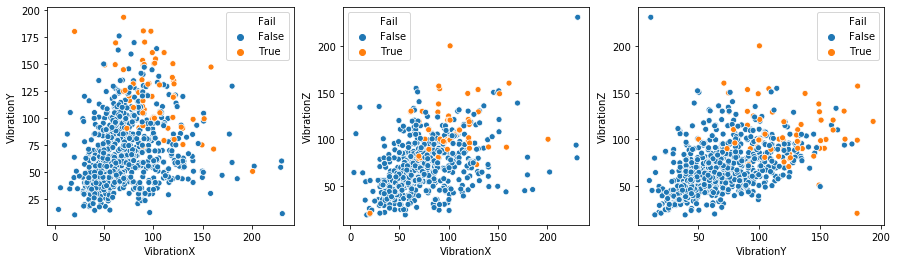

In [65]:
plt.figure(figsize=(15,4))
plt.subplot(131)
sb.scatterplot(df['VibrationX'],df['VibrationY'],hue=df.Fail)
plt.subplot(132)
sb.scatterplot(df['VibrationX'],df['VibrationZ'],hue=df.Fail)
plt.subplot(133)
sb.scatterplot(df['VibrationY'],df['VibrationZ'],hue=df.Fail)

In [66]:
pca=skdc.PCA()

In [67]:
pca=pca.fit(df[['VibrationX', 'VibrationY', 'VibrationZ']].loc[:600])

In [68]:
df['VibrationA']=np.dot(df[['VibrationX', 'VibrationY', 'VibrationZ']],pca.components_[0])
df['VibrationB']=np.dot(df[['VibrationX', 'VibrationY', 'VibrationZ']],pca.components_[1])
df['VibrationC']=np.dot(df[['VibrationX', 'VibrationY', 'VibrationZ']],pca.components_[2])

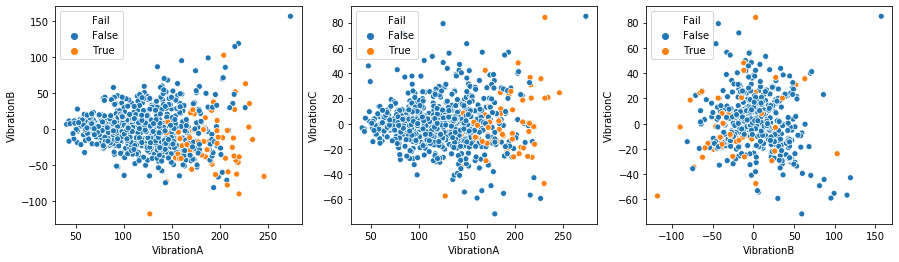

In [69]:
plt.figure(figsize=(15,4))
plt.subplot(131)
sb.scatterplot(df['VibrationA'],df['VibrationB'],hue=df.Fail)
plt.subplot(132)
sb.scatterplot(df['VibrationA'],df['VibrationC'],hue=df.Fail)
plt.subplot(133)
sb.scatterplot(df['VibrationB'],df['VibrationC'],hue=df.Fail)

In [70]:
df[df.columns[df.columns.str.contains('Vibration')]].corr().round(4)

VibrationX  VibrationY  VibrationZ  VibrationA  VibrationB  \
VibrationX      1.0000      0.2214      0.5118      0.7449      0.5810   
VibrationY      0.2214      1.0000      0.5057      0.7504     -0.6646   
VibrationZ      0.5118      0.5057      1.0000      0.8436     -0.0083   
VibrationA      0.7449      0.7504      0.8436      1.0000     -0.0472   
VibrationB      0.5810     -0.6646     -0.0083     -0.0472      1.0000   
VibrationC     -0.2512     -0.1816      0.5476      0.0144     -0.0136   

            VibrationC  
VibrationX     -0.2512  
VibrationY     -0.1816  
VibrationZ      0.5476  
VibrationA      0.0144  
VibrationB     -0.0136  
VibrationC      1.0000

With this transformation, the new axis are not correlated at all. Also, we can see that the main new axis of vibration (A) is a good  we can create a simple threshold around $Vibration_A = 125$, in which there's no failed cycles below.<br>
Also, one could notice that I made the A,B & C variables manually. It was on purpose so that we maintain the center of vibration on the (0,0,0) point, as we can see below:

In [71]:
df['Radius']=np.sqrt(df['VibrationX']**2+df['VibrationY']**2+df['VibrationZ']**2)
df['Radius2']=np.sqrt(df['VibrationA']**2+df['VibrationB']**2+df['VibrationC']**2)

In [72]:
df[['Radius','Radius2']].head()

Radius     Radius2
0  103.801329  103.801329
1  130.232621  130.232621
2  161.994313  161.994313
3  209.236814  209.236814
4   90.029176   90.029176

In [73]:
df=df.drop('Radius2',axis=1)

Now, let's calculate a new radius taking into account the eigenvalues of the PCA transformation.

In [74]:
df['Radius_Norm']=np.sqrt((df['VibrationA']/pca.singular_values_[0])**2+
                          (df['VibrationB']/pca.singular_values_[1])**2+
                          (df['VibrationC']/pca.singular_values_[2])**2)

Also, let's calculate a new delta for the axis A,B & C.

In [75]:
df['DeltaA']=df['VibrationA']-df['VibrationA'].shift(1)
df['DeltaB']=df['VibrationB']-df['VibrationB'].shift(1)
df['DeltaC']=df['VibrationC']-df['VibrationC'].shift(1)

In [76]:
df['ArcBA']=np.arctan(df['VibrationB']/df['VibrationA'])
df['ArcCA']=np.arctan(df['VibrationC']/df['VibrationA'])
df['ArcCB']=np.arctan(df['VibrationC']/df['VibrationB'])

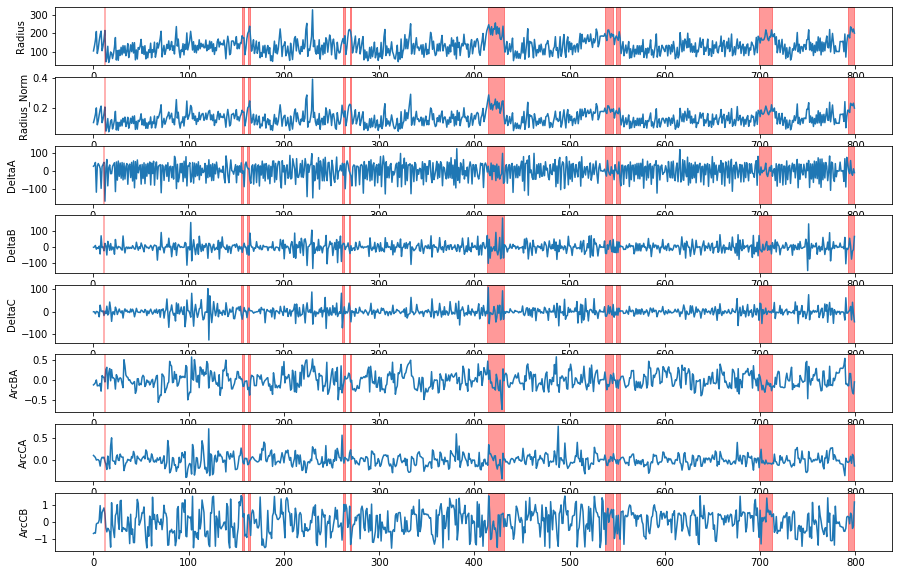

In [77]:
plt.figure(figsize=(15,10))
idx=['Radius','Radius_Norm','DeltaA','DeltaB','DeltaC','ArcBA','ArcCA','ArcCB']
for i in range(len(idx)):
    plt.subplot(len(idx),1,i+1)
    plt.plot(df.loc[:,idx[i]])
    plt.ylabel(idx[i])
    for f in ls:
        if hasattr(f,'__iter__'):
            plt.axvspan(fails[f[0]],fails[f[1]],color='r',alpha=0.4)
        else:
            plt.axvline(fails[int(f)],color='r',alpha=0.4)

# 4. Create a model using the technique you think is most appropriate and measure its performance


Obs.: I'm using the sklearn 0.23.1 version with the imblearn 0.7.0. <i>Using other versions may cause errors.</i>

Obs.2: I'll be using the True f1-score as my metric. This way, we can ignore a bit the imbalance of the data. Also, I'll be changing the threshold of the models to get the best f1-score.

In [78]:
import sklearn.tree as tree
import sklearn.metrics as metrics
import scikitplot as skplt
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import imblearn
import sklearn.ensemble as skens
import xgboost
import sklearn.svm
import sklearn.neural_network as sknn

In [79]:
idx_start=np.where(df.loc[600:].start)

In [80]:
for col in df.columns[df.columns.str.startswith('Delta')]:
    df[col]=df[col].fillna(0)

In [81]:
Xcols=['Temperature', 'Pressure','Frequency','VibrationA', 'VibrationB', 'VibrationC',
       'DeltaA', 'DeltaB', 'DeltaC','Radius', 'Radius_Norm','ArcBA', 'ArcCA','ArcCB', 'Preset_1@2', 'Preset_1@3',
       'Preset_2@2', 'Preset_2@3', 'Preset_2@4', 'Preset_2@5', 'Preset_2@6','Preset_2@7', 'Preset_2@8']

In [82]:
X_train=df.loc[:600,Xcols]
X_test=df.loc[600:,Xcols]
y_train=df.loc[:600,'Fail']
y_test=df.loc[600:,'Fail']

In [83]:
sc=MinMaxScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [84]:
smote=imblearn.over_sampling.SMOTE(sampling_strategy=0.2,n_jobs=5,random_state=314)

In [85]:
X_re,y_re=smote.fit_resample(X_train,y_train)

In [86]:
tr=tree.DecisionTreeClassifier(max_depth=6,random_state=314,class_weight={False:1,True:5})
rf=skens.RandomForestClassifier(n_jobs=5,max_depth=15,class_weight={False:1,True:10},random_state=314)
xgb=xgboost.XGBClassifier(max_depth=6,random_state=314,verbosity=0)
svm=sklearn.svm.SVC(kernel='rbf',probability=True)
rl=sklm.LogisticRegression(n_jobs=5,max_iter=2e3,class_weight={False:1,True:1},random_state=314)
nn=sknn.MLPClassifier((128,64,128),max_iter=500)

models=[tr,rf,xgb,svm,rl,nn]

In [87]:
results=pd.DataFrame(columns=['model','f1-score','threshold'])

In [88]:
seq=np.arange(1,0,-0.01)

In [89]:
for clf in models:
    clf.fit(X_re,y_re)
    f1_max=0
    threshold=0
    for i in seq:
        f1=metrics.f1_score(clf.predict_proba(X_test)[:,1]>i,y_test)
        if f1>f1_max:
            f1_max=f1
            threshold=i
    results=results.append(pd.DataFrame({'model':[str(type(clf))],'f1-score':[f1_max],'threshold':[threshold]}))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [90]:
results

model  f1-score  threshold
0  <class 'sklearn.tree._classes.DecisionTreeClas...  0.695652       0.90
0  <class 'sklearn.ensemble._forest.RandomForestC...  0.800000       0.39
0            <class 'xgboost.sklearn.XGBClassifier'>  0.816327       0.17
0                 <class 'sklearn.svm._classes.SVC'>  0.840000       0.16
0  <class 'sklearn.linear_model._logistic.Logisti...  0.823529       0.28
0  <class 'sklearn.neural_network._multilayer_per...  0.826087       0.01

Tree-based models performed poorly in this dataset, giving room to the models with a geometric-based approach. If this type of data was merely tabular, the support-vector machine model would be the better one to use.

## Time-series sequence approach

For this approach, we will use LSTM's to predict.

In [91]:
import tensorflow as tf

import tensorflow.keras.layers as Layers
import tensorflow.keras.optimizers as opt
import tensorflow.keras.optimizers

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import History, EarlyStopping
import keras.backend

In [92]:
df.columns

Index(['Cycle', 'Temperature', 'Pressure', 'VibrationX', 'VibrationY',
       'VibrationZ', 'Frequency', 'Fail', 'end', 'start', 'pre', 'DeltaX',
       'DeltaY', 'DeltaZ', 'Previous_T', 'Preset_1@2', 'Preset_1@3',
       'Preset_2@2', 'Preset_2@3', 'Preset_2@4', 'Preset_2@5', 'Preset_2@6',
       'Preset_2@7', 'Preset_2@8', 'VibrationA', 'VibrationB', 'VibrationC',
       'Radius', 'Radius_Norm', 'DeltaA', 'DeltaB', 'DeltaC', 'ArcBA', 'ArcCA',
       'ArcCB'],
      dtype='object')

We won't use some values like DeltaA or Previous_T since they will be passed with the sequence.

In [93]:
Xcols=['Temperature', 'Pressure','Frequency','VibrationA','VibrationB', 'VibrationC','Radius_Norm','Radius',
      'ArcBA', 'ArcCA','ArcCB','Preset_2@4']

In [94]:
df_X=df[np.concatenate([['Fail'],Xcols])]

In [95]:
sc.fit(df_X.loc[:600])

MinMaxScaler()

In [96]:
df_X=sc.transform(df_X)

In [97]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [98]:
lb=5
X_seq,y_seq=create_dataset(df_X,lb)
y_seq=y_seq.astype(bool)

In [99]:
X_train=X_seq[:600]
X_test=X_seq[600:]
y_train=y_seq[:600]
y_test=y_seq[600:]

#### SMOTE

We'll resort to a larger proportion of SMOTE since a small one would lead the model to predict only to the major class (I tried that).

In [100]:
s0=X_train.shape

In [101]:
X_train=X_train.reshape(s0[0],-1)

In [102]:
smote=imblearn.over_sampling.SMOTE(sampling_strategy=0.8,n_jobs=5,random_state=314)

In [103]:
X_re,y_re=smote.fit_resample(X_train,y_train)

In [104]:
X_re=X_re.reshape(-1,s0[1],s0[2])

### Model

In [105]:
def precision(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + keras.backend.epsilon())
    return precision_keras

def recall(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + keras.backend.epsilon())
    return recall_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + keras.backend.epsilon()))

In [106]:
model = Sequential()
model.add(LSTM(64, input_shape=s0[1:],dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mse', optimizer='adam',metrics=['accuracy',f1])

In [107]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                19712     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________


In [108]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
hs=History()

In [109]:
model.fit(X_re, y_re, epochs=300, batch_size=50, validation_split=0.25,verbose=2,callbacks=[es,hs])

Epoch 1/300
15/15 - 4s - loss: 0.2192 - accuracy: 0.7120 - f1: 0.0558 - val_loss: 0.5001 - val_accuracy: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/300
15/15 - 0s - loss: 0.1865 - accuracy: 0.7413 - f1: 0.0000e+00 - val_loss: 0.5072 - val_accuracy: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/300
15/15 - 0s - loss: 0.1626 - accuracy: 0.7547 - f1: 0.0781 - val_loss: 0.3170 - val_accuracy: 0.2640 - val_f1: 0.4147
Epoch 4/300
15/15 - 0s - loss: 0.1313 - accuracy: 0.8267 - f1: 0.5529 - val_loss: 0.3116 - val_accuracy: 0.4760 - val_f1: 0.6444
Epoch 5/300
15/15 - 0s - loss: 0.1163 - accuracy: 0.8320 - f1: 0.6187 - val_loss: 0.1897 - val_accuracy: 0.7240 - val_f1: 0.8393
Epoch 6/300
15/15 - 0s - loss: 0.1047 - accuracy: 0.8587 - f1: 0.6815 - val_loss: 0.1976 - val_accuracy: 0.7200 - val_f1: 0.8365
Epoch 7/300
15/15 - 0s - loss: 0.1035 - accuracy: 0.8600 - f1: 0.7114 - val_loss: 0.1148 - val_accuracy: 0.8240 - val_f1: 0.9030
Epoch 8/300
15/15 - 0s - loss: 0.1026 - accuracy: 0.8480 - f1: 0.6775 - val_l

Epoch 64/300
15/15 - 0s - loss: 0.0682 - accuracy: 0.9133 - f1: 0.8272 - val_loss: 0.0711 - val_accuracy: 0.9200 - val_f1: 0.9578
Epoch 65/300
15/15 - 0s - loss: 0.0658 - accuracy: 0.9147 - f1: 0.8349 - val_loss: 0.0790 - val_accuracy: 0.9120 - val_f1: 0.9534
Epoch 66/300
15/15 - 0s - loss: 0.0682 - accuracy: 0.9013 - f1: 0.8084 - val_loss: 0.0787 - val_accuracy: 0.9120 - val_f1: 0.9534
Epoch 67/300
15/15 - 0s - loss: 0.0637 - accuracy: 0.9187 - f1: 0.8392 - val_loss: 0.0642 - val_accuracy: 0.9240 - val_f1: 0.9600
Epoch 68/300
15/15 - 0s - loss: 0.0648 - accuracy: 0.9147 - f1: 0.8275 - val_loss: 0.0510 - val_accuracy: 0.9400 - val_f1: 0.9687
Epoch 69/300
15/15 - 0s - loss: 0.0577 - accuracy: 0.9213 - f1: 0.8351 - val_loss: 0.0532 - val_accuracy: 0.9360 - val_f1: 0.9665
Epoch 70/300
15/15 - 0s - loss: 0.0585 - accuracy: 0.9240 - f1: 0.8519 - val_loss: 0.0399 - val_accuracy: 0.9520 - val_f1: 0.9749
Epoch 71/300
15/15 - 0s - loss: 0.0589 - accuracy: 0.9240 - f1: 0.8425 - val_loss: 0.0465 

Epoch 127/300
15/15 - 0s - loss: 0.0542 - accuracy: 0.9267 - f1: 0.8566 - val_loss: 0.0285 - val_accuracy: 0.9720 - val_f1: 0.9856
Epoch 128/300
15/15 - 0s - loss: 0.0541 - accuracy: 0.9253 - f1: 0.8579 - val_loss: 0.0560 - val_accuracy: 0.9360 - val_f1: 0.9665
Epoch 129/300
15/15 - 0s - loss: 0.0536 - accuracy: 0.9293 - f1: 0.8558 - val_loss: 0.0315 - val_accuracy: 0.9640 - val_f1: 0.9811
Epoch 130/300
15/15 - 0s - loss: 0.0538 - accuracy: 0.9240 - f1: 0.8486 - val_loss: 0.0347 - val_accuracy: 0.9640 - val_f1: 0.9811
Epoch 131/300
15/15 - 0s - loss: 0.0556 - accuracy: 0.9307 - f1: 0.8686 - val_loss: 0.0473 - val_accuracy: 0.9360 - val_f1: 0.9665
Epoch 132/300
15/15 - 0s - loss: 0.0596 - accuracy: 0.9187 - f1: 0.8343 - val_loss: 0.0258 - val_accuracy: 0.9760 - val_f1: 0.9877
Epoch 133/300
15/15 - 0s - loss: 0.0577 - accuracy: 0.9200 - f1: 0.8324 - val_loss: 0.0471 - val_accuracy: 0.9560 - val_f1: 0.9773
Epoch 134/300
15/15 - 0s - loss: 0.0625 - accuracy: 0.9133 - f1: 0.8308 - val_loss:

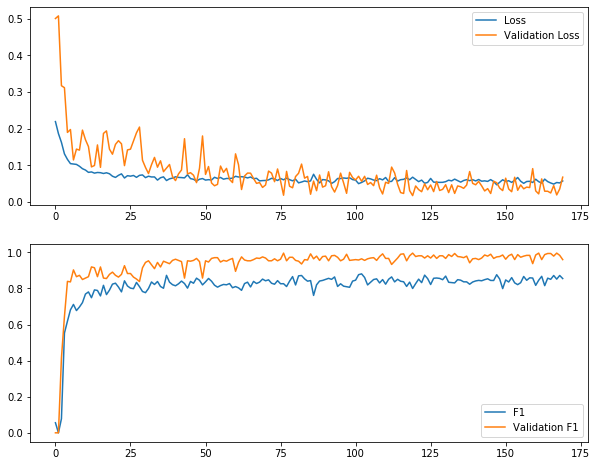

In [111]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['Loss','Validation Loss'])
plt.subplot(212)
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.legend(['F1','Validation F1'])

In [112]:
prob=model.predict_proba(X_test)
#prob=np.hstack([1-prob,prob])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [113]:
f1_max=0
threshold=0
for i in seq:
    f1_=metrics.f1_score(model.predict_proba(X_test).ravel()>i,y_test)
    if f1_>f1_max:
        f1_max=f1_
        threshold=i

In [114]:
f1_max,threshold

(0.7619047619047619, 0.3099999999999994)

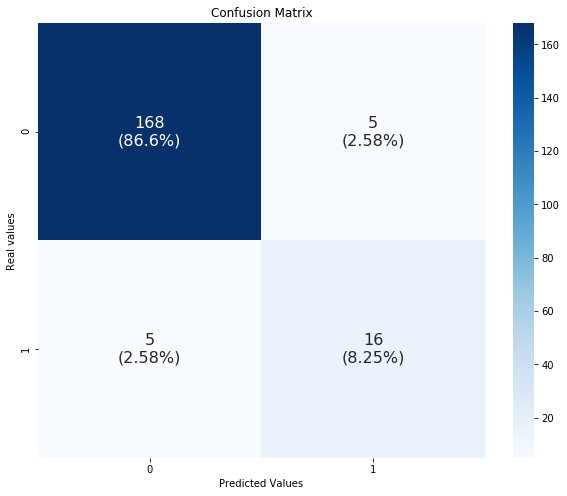

In [116]:
thiago.confusion_matrix_custom(prob>0.31,y_test,main='Confusion Matrix',
    xlab='Predicted Values',ylab='Real values')

## Explaining the model

### SVM

In [118]:
import shap
shap.initjs()

In [119]:
Xcols=['Temperature', 'Pressure','Frequency','VibrationA', 'VibrationB', 'VibrationC',
       'DeltaA', 'DeltaB', 'DeltaC','Radius', 'Radius_Norm','ArcBA', 'ArcCA','ArcCB', 'Preset_1@2', 'Preset_1@3',
       'Preset_2@2', 'Preset_2@3', 'Preset_2@4', 'Preset_2@5', 'Preset_2@6','Preset_2@7', 'Preset_2@8']

X_train=df.loc[:600,Xcols]
X_test=df.loc[600:,Xcols]

sc=MinMaxScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [120]:
exp=shap.KernelExplainer(svm.predict_proba,shap.kmeans(X_train,10),link='logit')

In [121]:
shap_values=exp.shap_values(X_test)

  0%|          | 0/200 [00:00<?, ?it/s]

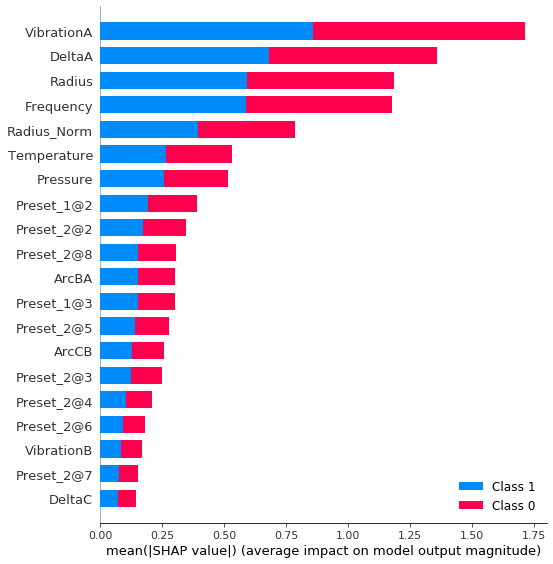

In [122]:
shap.summary_plot(shap_values,features=Xcols)

The variables with the biggest impact in the SVM model are Vibration A, DeltaA (difference of vibration in A-axis between cycles), Radius (total vibration in all axis), Frequency, Radius_Norm,Temperature and Pressure. The others are almost irrelevant.

### Logistic Regression

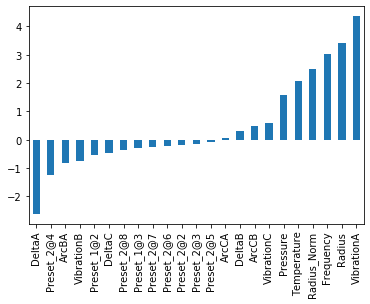

In [123]:
pd.Series(rl.coef_[0],index=Xcols).sort_values().plot.bar()

With this plot, we can understand how the most important variables affect the prediction. In summary, high values of VibrationA, Radius, Frequency, Radius_Norm,Temperature and Pressure tends to increase the failures probability. On the other hand, high values of DeltaA decreases the chance of failure.<br>
This could suggest that a failure occur mainly when the equipment slows down after an operational peak.

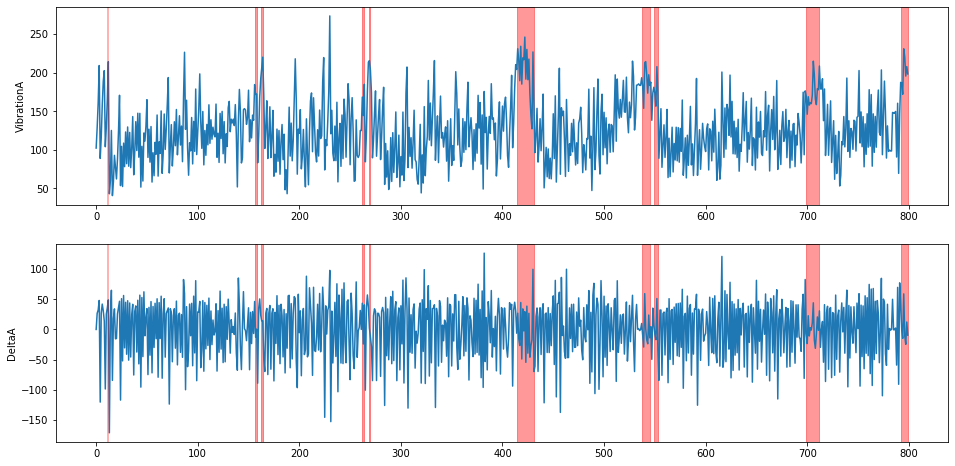

In [125]:
plt.figure(figsize=(16,8))
idx=['VibrationA','DeltaA']
for i in range(len(idx)):
    plt.subplot(len(idx),1,i+1)
    plt.plot(df.loc[:,idx[i]])
    plt.ylabel(idx[i])
    for f in ls:
        if hasattr(f,'__iter__'):
            plt.axvspan(fails[f[0]],fails[f[1]],color='r',alpha=0.4)
        else:
            plt.axvline(fails[int(f)],color='r',alpha=0.4)

## Conclusion

The best models to predict failures in this dataset were the SVM and the logistic regression models. Tree-based models such as XGBoost had a worse performance. The same goes to the time-series approach with the LSTM. This may happen due to the low quantity of observations.<br><br>
We changed the vibration axis from X,Y and Z to A,B and C in order to get a cleaner signal of the vibration. The result was really positive, being the two most important features related to the vibration in the new A-axis.<br><br>
The best model was the SVM, with a F1-score of 84% followed by the logistic regression with 82%. The F1-score metric was chosen to compensate the imbalance in the data and the lack of cost information of each kind of error.<br><br>
